In [2]:
# 02_models_baseline_and_lstm.ipynb
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

import joblib

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (8,5)

BASE_DIR = Path.cwd().parent          # repo root (.. from notebooks/)
DATA_DIR = BASE_DIR / "data" / "FD001"
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

print("DATA_DIR:", DATA_DIR)


DATA_DIR: C:\Users\harsh\Projects\NASA_TurboFan_RUL\data\FD001


In [4]:
COLS = ["unit", "cycle", "setting1", "setting2", "setting3"] + [f"s{i}" for i in range(1,22)]

def load_fd(path_train, path_test, path_rul):
    for p in (path_train, path_test, path_rul):
        assert Path(p).exists(), f"Missing {p}"
    train = pd.read_csv(path_train, sep=r"\s+", header=None)
    test  = pd.read_csv(path_test,  sep=r"\s+", header=None)
    rul   = pd.read_csv(path_rul,   sep=r"\s+", header=None)
    if train.shape[1] > 26: train = train.iloc[:, :26]
    if test.shape[1]  > 26: test  = test.iloc[:,  :26]
    train.columns = COLS; test.columns = COLS; rul.columns = ["RUL"]
    return train, test, rul

def add_rul_labels(train, test, rul):
    # Train labels
    max_cycle_train = train.groupby("unit")["cycle"].max().rename("max_cycle")
    train = train.merge(max_cycle_train, on="unit")
    train["RUL"] = train["max_cycle"] - train["cycle"]
    train.drop(columns=["max_cycle"], inplace=True)

    # Test labels (map RUL vector to sorted unit ids)
    last_test = test.groupby("unit")["cycle"].max().reset_index(name="last_cycle")
    units_sorted = pd.DataFrame({"unit": sorted(test["unit"].unique())})
    assert len(units_sorted) == len(rul), "Units and RUL length mismatch"
    units_sorted["RUL_at_last"] = rul["RUL"].values
    fail_map = last_test.merge(units_sorted, on="unit")
    fail_map["failure_cycle"] = fail_map["last_cycle"] + fail_map["RUL_at_last"]
    test = test.merge(fail_map[["unit","failure_cycle"]], on="unit", how="left")
    test["true_RUL"] = test["failure_cycle"] - test["cycle"]
    test["true_RUL"] = test["true_RUL"].clip(lower=0)
    return train, test

train_raw, test_raw, rul = load_fd(
    DATA_DIR / "train_FD001.txt",
    DATA_DIR / "test_FD001.txt",
    DATA_DIR / "RUL_FD001.txt",
)
train_lbl, test_lbl = add_rul_labels(train_raw.copy(), test_raw.copy(), rul.copy())

print(train_lbl.shape, test_lbl.shape)


(20631, 27) (13096, 28)


In [14]:
def select_informative_columns(df_train, df_test, threshold=1e-8):
    sensor_cols = [c for c in df_train.columns if c.startswith("s")]
    setting_cols = ["setting1","setting2"]  # setting3 is nearly constant on FD001
    # variance on train only
    var = df_train[sensor_cols].var()
    keep_sensors = var[var > threshold].index.tolist()
    keep = ["unit","cycle"] + setting_cols + keep_sensors
    return df_train[keep].copy(), df_test[keep].copy(), keep

train_feats, test_feats, kept_cols = select_informative_columns(train_lbl, test_lbl)
print("Kept columns:", len(kept_cols), " (incl. unit, cycle)")


Kept columns: 21  (incl. unit, cycle)


In [20]:
print("kept_cols (first 10):", kept_cols[:10])
base_cols = [c for c in kept_cols if c not in ("unit","cycle")]
print("len(base_cols) =", len(base_cols))
print("missing in train_feats:", [c for c in base_cols if c not in train_feats.columns][:10])


kept_cols (first 10): ['unit', 'cycle', 'setting1', 'setting2', 'setting1', 'setting2', 's2', 's3', 's4', 's6']
len(base_cols) = 19
missing in train_feats: []


In [26]:
def dup_cols(df):
    counts = df.columns.value_counts()
    return counts[counts > 1]

print("Dups in train_feats:\n", dup_cols(train_feats))
print("Dups in test_feats:\n", dup_cols(test_feats))


Dups in train_feats:
 setting1    2
setting2    2
Name: count, dtype: int64
Dups in test_feats:
 setting1    2
setting2    2
Name: count, dtype: int64


In [28]:
# Ensure no duplicated column names in feature frames
train_feats = train_feats.loc[:, ~train_feats.columns.duplicated()].copy()
test_feats  = test_feats.loc[:,  ~test_feats.columns.duplicated()].copy()

# Also make the kept list unique while preserving order
def unique_preserve(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            out.append(x); seen.add(x)
    return out

kept_cols = unique_preserve(kept_cols)


In [30]:
base_cols = [c for c in kept_cols if c not in ("unit","cycle")]
print("len(base_cols) =", len(base_cols))


len(base_cols) = 17


In [52]:
def add_rolling_stats(df, base_cols, windows=(5, 15)):
    df = df.sort_values(["unit", "cycle"]).copy()

    # keep only columns that actually exist
    base_cols = [c for c in base_cols if c in df.columns]

    # cast to numeric per column (now guaranteed Series, not DataFrame)
    for c in base_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    g = df.groupby("unit", group_keys=False)

    for w in windows:
        for col in base_cols:
            df[f"{col}_mean_{w}"] = g[col].transform(lambda s: s.rolling(w, min_periods=1).mean())
            df[f"{col}_std_{w}"]  = g[col].transform(lambda s: s.rolling(w, min_periods=1).std()).fillna(0.0)

    return df

train_f = add_rolling_stats(train_feats, base_cols, windows=(5,15,30))
test_f  = add_rolling_stats(test_feats,  base_cols, windows=(5,15,30))

print(train_f.shape, test_f.shape)


C:\Users\harsh\AppData\Local\Temp\ipykernel_22120\618202405.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_mean_{w}"] = g[col].transform(lambda s: s.rolling(w, min_periods=1).mean())
C:\Users\harsh\AppData\Local\Temp\ipykernel_22120\618202405.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_std_{w}"]  = g[col].transform(lambda s: s.rolling(w, min_periods=1).std()).fillna(0.0)
C:\Users\harsh\AppData\Local\Temp\ipykernel_22120\618202405.py:15: PerformanceWarning: DataFrame is highly fragmented.  Thi

(20631, 121) (13096, 121)


C:\Users\harsh\AppData\Local\Temp\ipykernel_22120\618202405.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_mean_{w}"] = g[col].transform(lambda s: s.rolling(w, min_periods=1).mean())
C:\Users\harsh\AppData\Local\Temp\ipykernel_22120\618202405.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_std_{w}"]  = g[col].transform(lambda s: s.rolling(w, min_periods=1).std()).fillna(0.0)
C:\Users\harsh\AppData\Local\Temp\ipykernel_22120\618202405.py:15: PerformanceWarning: DataFrame is highly fragmented.  Thi

In [54]:
scaler = StandardScaler()
feat_cols = [c for c in train_f.columns if c not in ("unit","cycle")]

train_scaled = train_f.copy()
test_scaled  = test_f.copy()
train_scaled[feat_cols] = scaler.fit_transform(train_f[feat_cols])
test_scaled[feat_cols]  = scaler.transform(test_f[feat_cols])

joblib.dump(scaler, MODEL_DIR / "scaler.pkl")
print("Scaled. Saved scaler.pkl")


Scaled. Saved scaler.pkl


In [56]:
# Use ALL train rows; last-row per unit only for test
feat_cols = [c for c in train_scaled.columns if c not in ("unit","cycle")]

# X/y for TRAIN: all rows
X_train = train_scaled[feat_cols].values
y_train = train_lbl["RUL"].values

# Optionally cap RUL (common practice): uncomment to try
# CAP = 125
# y_train = np.minimum(y_train, CAP)

# TEST: last observed row per unit (predict "now")
idx_last = test_scaled.groupby("unit")["cycle"].idxmax()
X_test  = test_scaled.loc[idx_last, feat_cols].values
y_test  = test_lbl.loc[idx_last, "true_RUL"].values

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((20631, 119), (100, 119), (20631,), (100,))

In [58]:
def rmse(y_true, y_pred): 
    return mean_squared_error(y_true, y_pred, squared=False)

def mae(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred)

def nasa_score(y_true, y_pred):
    d = y_pred - y_true
    s = np.where(d < 0, np.exp(-d/13)-1, np.exp(d/10)-1)
    return float(np.sum(s))


In [60]:
CAP = 125
y_train_capped = np.minimum(y_train, CAP)

rf  = RandomForestRegressor(n_estimators=800, random_state=42, n_jobs=-1)
gbr = GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=1200, max_depth=3)

def fit_eval_y(model, Xtr, ytr, name):
    model.fit(Xtr, ytr)
    pred = model.predict(X_test)
    print(f"{name}: RMSE={rmse(y_test,pred):.2f}  MAE={mae(y_test,pred):.2f}  NASA={nasa_score(y_test,pred):.1f}")
    return model, pred

rf_model,  rf_pred  = fit_eval_y(rf,  X_train, y_train_capped, "RF (capped)")
gbr_model, gbr_pred = fit_eval_y(gbr, X_train, y_train_capped, "GBR (capped)")


RF (capped): RMSE=18.26  MAE=13.52  NASA=806.2
GBR (capped): RMSE=16.97  MAE=12.89  NASA=533.4


Best: gbr


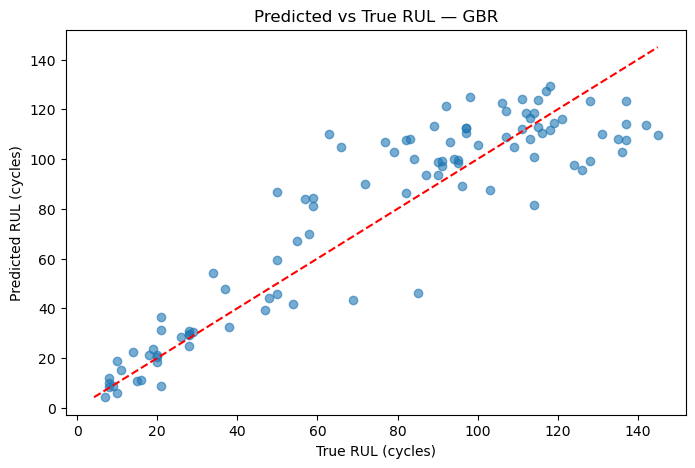

Saved: C:\Users\harsh\Projects\NASA_TurboFan_RUL\models\rul_baseline_gbr.pkl


In [62]:
models = [("rf", rf_model, rf_pred), ("gbr", gbr_model, gbr_pred)]
best_name, best_model, best_pred = sorted(models, key=lambda t: rmse(y_test, t[2]))[0]
print("Best:", best_name)

# Plot
import matplotlib.pyplot as plt
plt.scatter(y_test, best_pred, alpha=0.6)
lims = [min(y_test.min(), best_pred.min()), max(y_test.max(), best_pred.max())]
plt.plot(lims, lims, "r--")
plt.xlabel("True RUL (cycles)"); plt.ylabel("Predicted RUL (cycles)")
plt.title(f"Predicted vs True RUL — {best_name.upper()}")
plt.show()

# Save scaler + model
joblib.dump(scaler, MODEL_DIR / "scaler.pkl")
out_path = MODEL_DIR / f"rul_baseline_{best_name}.pkl"
joblib.dump(best_model, out_path)
print("Saved:", out_path)
